# IMPORT PACKAGES

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# IMPORT DATA

In [2]:
# Create column names for pandas dataframe
# 'dat_cols' pertains to the default .DAT file from the vector, 'sen_cols' pertains to the default .SEN file
dat_cols = ["Burst_counter", "Ensemble_counter", "Velocity_East(m/s)", "Velocity_North(m/s)", "Velocity_Up(m/s)", "Amplitude_B1(counts)",
            "Amplitude_B2(counts)", "Amplitude_B3(counts)", "SNR_B1(dB)", "SNR_B2(dB)", "SNR_B3(dB)", "Correlation_B1(%)", "Correlation_B2(%)",
            "Correlation_B3(%)", "Pressure(dbar)", "AnalogInput1", "AnalogInput2", "Checksum(1=failed)"]
sen_cols = ["Month", "Day", "Year", "Hour", "Minute", "Second", "Error_code", "Status_code", "Battery_voltage", "Soundspeed", "Heading", "Pitch", "Roll", "Temperature",
           "Analog_input", "Checksum"]

In [3]:
# Import both the raw velocity data files and the .SEN files for date and time meta data
#ADV1 = pd.read_csv('ADV/DEPL_204a.DAT', delimiter='\s+', names = dat_cols)
#ADV1_sen=pd.read_csv('ADV/DEPL_204a_sen.SEN', delimiter='\s+', names=sen_cols)
#ADV2 = pd.read_csv('ADV/DEP205.DAT', delimiter='\s+', names = dat_cols)
#ADV2_sen=pd.read_csv('ADV/DEP205.sen', delimiter='\s+', names=sen_cols)

In [60]:
len(ADV1_sen)

270225

In [57]:
len(ADV2)

14204761

# CREATE DATAFRAME

In [53]:
# .DAT file contains data at 32Hz but has no timestamp, .SEN file only has timestamps every second
# A custom datetime range at 32Hz must be created for the .DAT file
# For every timestamp at 1 second in the .SEN file, the following loop generates a time every 31.25 milliseconds
# OUTPUT: 32 datetimes every second while still keeping consistent with realtime data
dates = pd.date_range(start=(str(ADV2_sen.iloc[0,0])+'/'+ str(ADV2_sen.iloc[0,1])+'/'+ str(ADV2_sen.iloc[0,2])+' '+ str(ADV2_sen.iloc[0,3])+':'+ 
                     str(ADV2_sen.iloc[0,4])+':'+ str(ADV2_sen.iloc[0,5])), periods=32, freq='31.25L')
for i in range(1, 444271, 1):
    new_dates = pd.date_range(start=(str(ADV2_sen.iloc[i,0])+'/'+ str(ADV2_sen.iloc[i,1])+'/'+ str(ADV2_sen.iloc[i,2])+' '+ str(ADV2_sen.iloc[i,3])+':'+ 
                     str(ADV2_sen.iloc[i,4])+':'+ str(ADV2_sen.iloc[i,5])), periods=32, freq='31.25L')
    dates = dates.append(new_dates)

In [55]:
len(dates)

14216672

In [61]:
dates01 = pd.date_range(start=(str(ADV1_sen.iloc[0,0])+'/'+ str(ADV1_sen.iloc[0,1])+'/'+ str(ADV1_sen.iloc[0,2])+' '+ str(ADV1_sen.iloc[0,3])+':'+ 
                     str(ADV1_sen.iloc[0,4])+':'+ str(ADV1_sen.iloc[0,5])), periods=32, freq='31.25L')
for i in range(1, 270225, 1):
    new_dates = pd.date_range(start=(str(ADV1_sen.iloc[i,0])+'/'+ str(ADV1_sen.iloc[i,1])+'/'+ str(ADV1_sen.iloc[i,2])+' '+ str(ADV1_sen.iloc[i,3])+':'+ 
                     str(ADV1_sen.iloc[i,4])+':'+ str(ADV1_sen.iloc[i,5])), periods=32, freq='31.25L')
    dates01 = dates01.append(new_dates)
    

In [63]:
# Add the new custom datetime ranges to the existing .DAT files, which are then exported as .csv appropriate column names
adv1_dt = dates01[0:8640000]
ADV1.insert(0, 'Datetime', adv1_dt)
ADV1
#ADV1.to_csv('ADV/ADV0802_0811.csv')

,Datetime,Burst_counter,Ensemble_counter,Velocity_East(m/s),Velocity_North(m/s),Velocity_Up(m/s),Amplitude_B1(counts),Amplitude_B2(counts),Amplitude_B3(counts),SNR_B1(dB),SNR_B2(dB),SNR_B3(dB),Correlation_B1(%),Correlation_B2(%),Correlation_B3(%),Pressure(dbar),AnalogInput1,AnalogInput2,Checksum(1=failed)
0,2022-08-02 09:40:02.000000,1,1,-0.128,-0.219,-0.110,42,43,43,-1.7,-1.3,-0.9,20,25,21,0.000,0,0,0
1,2022-08-02 09:40:02.031250,1,2,0.272,-0.216,-0.220,42,43,42,-1.7,-1.3,-1.3,21,16,30,0.000,0,0,0
2,2022-08-02 09:40:02.062500,1,3,0.484,1.625,0.442,41,41,43,-2.1,-2.1,-0.9,15,31,32,0.000,0,0,0
3,2022-08-02 09:40:02.093750,1,4,1.285,0.047,-0.538,44,41,43,-0.9,-2.1,-0.9,24,23,7,0.000,0,0,0
4,2022-08-02 09:40:02.125000,1,5,1.711,0.779,-0.097,42,45,43,-1.7,-0.4,-0.9,12,22,24,0.000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639995,2022-08-11 17:56:17.843750,225,38396,-0.871,-1.739,0.407,40,40,40,-0.4,-0.4,-0.4,17,25,16,0.024,0,0,0
8639996,2022-08-11 17:56:17.875000,225,38397,-0.311,0.232,-0.375,42,41,42,0.4,0.0,0.4,2,13,37,0.000,0,0,0
8639997,2022-08-11 17:56:17.906250,225,38398,-0.679,1.562,-1.043,39,41,43,-0.9,0.0,0.9,43,27,7,0.000,0,0,0
8639998,2022-08-11 17:56:17.937500,225,38399,-0.345,-0.948,0.516,40,41,39,-0.4,0.0,-0.9,18,29,13,0.000,0,0,0


In [60]:
# Add the heading, pitch, and roll columns to the timestamped dataset
ADV1 = pd.read_csv('ADV/ADV0802_0811.csv', index_col= False)
ADV1.drop(ADV1.columns[0], axis=1, inplace=True)
ADV1

,Datetime,Burst_counter,Ensemble_counter,Velocity_East(m/s),Velocity_North(m/s),Velocity_Up(m/s),Amplitude_B1(counts),Amplitude_B2(counts),Amplitude_B3(counts),SNR_B1(dB),SNR_B2(dB),SNR_B3(dB),Correlation_B1(%),Correlation_B2(%),Correlation_B3(%),Pressure(dbar),AnalogInput1,AnalogInput2,Checksum(1=failed)
0,2022-08-02 09:40:02.000000,1,1,-0.128,-0.219,-0.110,42,43,43,-1.7,-1.3,-0.9,20,25,21,0.000,0,0,0
1,2022-08-02 09:40:02.031250,1,2,0.272,-0.216,-0.220,42,43,42,-1.7,-1.3,-1.3,21,16,30,0.000,0,0,0
2,2022-08-02 09:40:02.062500,1,3,0.484,1.625,0.442,41,41,43,-2.1,-2.1,-0.9,15,31,32,0.000,0,0,0
3,2022-08-02 09:40:02.093750,1,4,1.285,0.047,-0.538,44,41,43,-0.9,-2.1,-0.9,24,23,7,0.000,0,0,0
4,2022-08-02 09:40:02.125000,1,5,1.711,0.779,-0.097,42,45,43,-1.7,-0.4,-0.9,12,22,24,0.000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639995,2022-08-11 17:56:17.843750,225,38396,-0.871,-1.739,0.407,40,40,40,-0.4,-0.4,-0.4,17,25,16,0.024,0,0,0
8639996,2022-08-11 17:56:17.875000,225,38397,-0.311,0.232,-0.375,42,41,42,0.4,0.0,0.4,2,13,37,0.000,0,0,0
8639997,2022-08-11 17:56:17.906250,225,38398,-0.679,1.562,-1.043,39,41,43,-0.9,0.0,0.9,43,27,7,0.000,0,0,0
8639998,2022-08-11 17:56:17.937500,225,38399,-0.345,-0.948,0.516,40,41,39,-0.4,0.0,-0.9,18,29,13,0.000,0,0,0


In [69]:
ADV1['Soundspeed'] = np.nan
ADV1['Heading'] = np.nan
ADV1['Pitch'] = np.nan
ADV1['Roll'] = np.nan
ADV1['Temperature'] = np.nan

,Datetime,Burst_counter,Ensemble_counter,Velocity_East(m/s),Velocity_North(m/s),Velocity_Up(m/s),Amplitude_B1(counts),Amplitude_B2(counts),Amplitude_B3(counts),SNR_B1(dB),...,Correlation_B3(%),Pressure(dbar),AnalogInput1,AnalogInput2,Checksum(1=failed),Soundspeed,Heading,Pitch,Roll,Temperature
0,2022-08-02 09:40:02.000000,1,1,-0.128,-0.219,-0.110,42,43,43,-1.7,...,21,0.000,0,0,0,NaN,NaN,NaN,NaN,NaN
1,2022-08-02 09:40:02.031250,1,2,0.272,-0.216,-0.220,42,43,42,-1.7,...,30,0.000,0,0,0,NaN,NaN,NaN,NaN,NaN
2,2022-08-02 09:40:02.062500,1,3,0.484,1.625,0.442,41,41,43,-2.1,...,32,0.000,0,0,0,NaN,NaN,NaN,NaN,NaN
3,2022-08-02 09:40:02.093750,1,4,1.285,0.047,-0.538,44,41,43,-0.9,...,7,0.000,0,0,0,NaN,NaN,NaN,NaN,NaN
4,2022-08-02 09:40:02.125000,1,5,1.711,0.779,-0.097,42,45,43,-1.7,...,24,0.000,0,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639995,2022-08-11 17:56:17.843750,225,38396,-0.871,-1.739,0.407,40,40,40,-0.4,...,16,0.024,0,0,0,NaN,NaN,NaN,NaN,NaN
8639996,2022-08-11 17:56:17.875000,225,38397,-0.311,0.232,-0.375,42,41,42,0.4,...,37,0.000,0,0,0,NaN,NaN,NaN,NaN,NaN
8639997,2022-08-11 17:56:17.906250,225,38398,-0.679,1.562,-1.043,39,41,43,-0.9,...,7,0.000,0,0,0,NaN,NaN,NaN,NaN,NaN
8639998,2022-08-11 17:56:17.937500,225,38399,-0.345,-0.948,0.516,40,41,39,-0.4,...,13,0.000,0,0,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
ADV1.iloc[0:32,19] = ADV1_sen.iloc[0, 9]
ADV1.iloc[0:32,20] = ADV1_sen.iloc[0, 10]
ADV1.iloc[0:32,21] = ADV1_sen.iloc[0, 11]
ADV1.iloc[0:32,22] = ADV1_sen.iloc[0, 12]
ADV1.iloc[0:32,23] = ADV1_sen.iloc[0, 13]
for i in range(1,270000,1):
    ADV1.iloc[(1 + (i*32)):((i+1)*32),19] = ADV1_sen.iloc[i, 9]
    ADV1.iloc[(1 + (i*32)):((i+1)*32),20] = ADV1_sen.iloc[i, 10]
    ADV1.iloc[(1 + (i*32)):((i+1)*32),21] = ADV1_sen.iloc[i, 11]
    ADV1.iloc[(1 + (i*32)):((i+1)*32),22] = ADV1_sen.iloc[i, 12]
    ADV1.iloc[(1 + (i*32)):((i+1)*32),23] = ADV1_sen.iloc[i, 13]

In [ ]:
#ADV1.to_csv('ADV1.csv')

In [58]:
adv2_dt = dates[0:14204761]
ADV2.insert(0, 'Datetime', adv2_dt)
#ADV2.to_csv('ADV/ADV0815_0830.csv')
ADV2 = pd.read_csv('ADV0815_0830.csv', index_col= False)
ADV2.drop(ADV2.columns[0], axis=1, inplace=True)

,Datetime,Burst_counter,Ensemble_counter,Velocity_East(m/s),Velocity_North(m/s),Velocity_Up(m/s),Amplitude_B1(counts),Amplitude_B2(counts),Amplitude_B3(counts),SNR_B1(dB),SNR_B2(dB),SNR_B3(dB),Correlation_B1(%),Correlation_B2(%),Correlation_B3(%),Pressure(dbar),AnalogInput1,AnalogInput2,Checksum(1=failed)
0,2022-08-15 06:40:02.000000,1,1,0.957,0.370,0.057,42,43,42,0.4,0.4,0.4,23,4,6,0.000,0,0,0
1,2022-08-15 06:40:02.031250,1,2,-0.231,-0.597,-0.259,41,40,41,0.0,-0.9,0.0,5,22,52,0.000,0,0,0
2,2022-08-15 06:40:02.062500,1,3,-0.842,0.547,0.416,43,40,42,0.9,-0.9,0.4,16,21,27,0.000,0,0,0
3,2022-08-15 06:40:02.093750,1,4,-0.082,0.171,-0.032,43,40,41,0.9,-0.9,0.0,24,31,29,0.000,0,0,0
4,2022-08-15 06:40:02.125000,1,5,-1.253,-0.233,0.554,41,42,41,0.0,0.0,0.0,34,34,34,0.000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14204756,2022-08-30 15:52:11.625000,370,35157,0.808,1.312,-0.313,39,39,39,-0.9,-1.3,-0.9,26,15,10,0.019,0,0,0
14204757,2022-08-30 15:52:11.656250,370,35158,0.401,-0.532,-0.033,41,40,41,0.0,-0.9,0.0,7,11,9,0.034,0,0,0
14204758,2022-08-30 15:52:11.687500,370,35159,-0.370,1.259,0.459,39,41,40,-0.9,-0.4,-0.4,15,20,11,0.024,0,0,0
14204759,2022-08-30 15:52:11.718750,370,35160,-0.370,1.259,0.459,39,41,40,-0.9,-0.4,-0.4,15,20,11,0.024,0,0,1


In [ ]:
ADV2['Soundspeed'] = np.nan
ADV2['Heading'] = np.nan
ADV2['Pitch'] = np.nan
ADV2['Roll'] = np.nan
ADV2['Temperature'] = np.nan

In [ ]:
ADV2.iloc[0:32,19] = ADV2_sen.iloc[0, 9]
ADV2.iloc[0:32,20] = ADV2_sen.iloc[0, 10]
ADV2.iloc[0:32,21] = ADV2_sen.iloc[0, 11]
ADV2.iloc[0:32,22] = ADV2_sen.iloc[0, 12]
ADV2.iloc[0:32,23] = ADV2_sen.iloc[0, 13]
for i in range(1,443897,1): # The last second of data gets cut off, so this only goes until the penultimate second of data
    ADV2.iloc[(1 + (i*32)):((i+1)*32),19] = ADV2_sen.iloc[i, 9]
    ADV2.iloc[(1 + (i*32)):((i+1)*32),20] = ADV2_sen.iloc[i, 10]
    ADV2.iloc[(1 + (i*32)):((i+1)*32),21] = ADV2_sen.iloc[i, 11]
    ADV2.iloc[(1 + (i*32)):((i+1)*32),22] = ADV2_sen.iloc[i, 12]
    ADV2.iloc[(1 + (i*32)):((i+1)*32),23] = ADV2_sen.iloc[i, 13]

In [ ]:
ADV2.to_csv('ADV2.csv')

In [ ]:
# Combine the two dataframes
ADV_combined = ADV1.append(ADV2)
ADV_combined

In [72]:
# Export to single .csv file
ADV_combined.to_csv('ADV/all_adv_data.csv')

# DATA QUALITY CONTROL

In [5]:
#ADV1 = pd.read_csv('ADV/ADV1.csv')
#ADV2 = pd.read_csv('ADV/ADV2.csv')

# When csv's are imported, an unnecessary index row is added
# These functions remove the 'unnamed' column
ADV1.drop(ADV1.columns[0], axis=1, inplace=True)
ADV2.drop(ADV2.columns[0], axis=1, inplace=True)

In [6]:
# Check to be sure nothing important got deleted
ADV1

,Datetime,Burst_counter,Ensemble_counter,Velocity_East(m/s),Velocity_North(m/s),Velocity_Up(m/s),Amplitude_B1(counts),Amplitude_B2(counts),Amplitude_B3(counts),SNR_B1(dB),...,Pressure(dbar),AnalogInput1,AnalogInput2,Checksum(1=failed),Soundspeed,Heading,Pitch,Roll,Temperature,Flag
0,2022-08-02 09:40:02.000000,1,1,-0.128,-0.219,-0.110,42,43,43,-1.7,...,0.000,0,0,0,1525.5,220.8,-5.9,-25.7,21.71,NaN
1,2022-08-02 09:40:02.031250,1,2,0.272,-0.216,-0.220,42,43,42,-1.7,...,0.000,0,0,0,1525.5,220.8,-5.9,-25.7,21.71,NaN
2,2022-08-02 09:40:02.062500,1,3,0.484,1.625,0.442,41,41,43,-2.1,...,0.000,0,0,0,1525.5,220.8,-5.9,-25.7,21.71,NaN
3,2022-08-02 09:40:02.093750,1,4,1.285,0.047,-0.538,44,41,43,-0.9,...,0.000,0,0,0,1525.5,220.8,-5.9,-25.7,21.71,NaN
4,2022-08-02 09:40:02.125000,1,5,1.711,0.779,-0.097,42,45,43,-1.7,...,0.000,0,0,0,1525.5,220.8,-5.9,-25.7,21.71,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639995,2022-08-11 17:56:17.843750,225,38396,-0.871,-1.739,0.407,40,40,40,-0.4,...,0.024,0,0,0,1532.0,15.0,-18.8,-22.3,24.02,NaN
8639996,2022-08-11 17:56:17.875000,225,38397,-0.311,0.232,-0.375,42,41,42,0.4,...,0.000,0,0,0,1532.0,15.0,-18.8,-22.3,24.02,NaN
8639997,2022-08-11 17:56:17.906250,225,38398,-0.679,1.562,-1.043,39,41,43,-0.9,...,0.000,0,0,0,1532.0,15.0,-18.8,-22.3,24.02,NaN
8639998,2022-08-11 17:56:17.937500,225,38399,-0.345,-0.948,0.516,40,41,39,-0.4,...,0.000,0,0,0,1532.0,15.0,-18.8,-22.3,24.02,NaN


#### Quality control parameters
- Data still contains deployment and retrieval values, as well as some 'bad' data points that must be filtered
- Use histograms to find out where outlier data lies:
    - Beam correlation
    - Roll and Pitch
    - Pressure
    - Phase wrapping

In [7]:
# Add qc columns to each dataframe
ADV1['Flag'] = 0
ADV2['Flag'] = 0

In [8]:
ADV1

,Datetime,Burst_counter,Ensemble_counter,Velocity_East(m/s),Velocity_North(m/s),Velocity_Up(m/s),Amplitude_B1(counts),Amplitude_B2(counts),Amplitude_B3(counts),SNR_B1(dB),...,Pressure(dbar),AnalogInput1,AnalogInput2,Checksum(1=failed),Soundspeed,Heading,Pitch,Roll,Temperature,Flag
0,2022-08-02 09:40:02.000000,1,1,-0.128,-0.219,-0.110,42,43,43,-1.7,...,0.000,0,0,0,1525.5,220.8,-5.9,-25.7,21.71,0
1,2022-08-02 09:40:02.031250,1,2,0.272,-0.216,-0.220,42,43,42,-1.7,...,0.000,0,0,0,1525.5,220.8,-5.9,-25.7,21.71,0
2,2022-08-02 09:40:02.062500,1,3,0.484,1.625,0.442,41,41,43,-2.1,...,0.000,0,0,0,1525.5,220.8,-5.9,-25.7,21.71,0
3,2022-08-02 09:40:02.093750,1,4,1.285,0.047,-0.538,44,41,43,-0.9,...,0.000,0,0,0,1525.5,220.8,-5.9,-25.7,21.71,0
4,2022-08-02 09:40:02.125000,1,5,1.711,0.779,-0.097,42,45,43,-1.7,...,0.000,0,0,0,1525.5,220.8,-5.9,-25.7,21.71,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639995,2022-08-11 17:56:17.843750,225,38396,-0.871,-1.739,0.407,40,40,40,-0.4,...,0.024,0,0,0,1532.0,15.0,-18.8,-22.3,24.02,0
8639996,2022-08-11 17:56:17.875000,225,38397,-0.311,0.232,-0.375,42,41,42,0.4,...,0.000,0,0,0,1532.0,15.0,-18.8,-22.3,24.02,0
8639997,2022-08-11 17:56:17.906250,225,38398,-0.679,1.562,-1.043,39,41,43,-0.9,...,0.000,0,0,0,1532.0,15.0,-18.8,-22.3,24.02,0
8639998,2022-08-11 17:56:17.937500,225,38399,-0.345,-0.948,0.516,40,41,39,-0.4,...,0.000,0,0,0,1532.0,15.0,-18.8,-22.3,24.02,0


### BEAM CORRELATION

<AxesSubplot:ylabel='Frequency'>

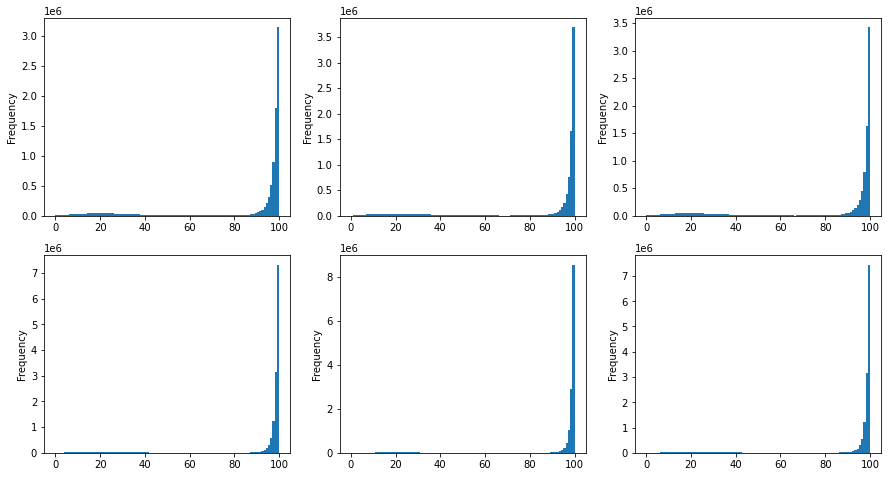

In [4]:
plt.figure(figsize = (15,8))
plt.subplot(231)
ADV1['Correlation_B1(%)'].plot.hist(bins=100)
plt.subplot(234)
ADV2['Correlation_B1(%)'].plot.hist(bins=100)

plt.subplot(232)
ADV1['Correlation_B2(%)'].plot.hist(bins=100)
plt.subplot(235)
ADV2['Correlation_B2(%)'].plot.hist(bins=100)

plt.subplot(233)
ADV1['Correlation_B3(%)'].plot.hist(bins=100)
plt.subplot(236)
ADV2['Correlation_B3(%)'].plot.hist(bins=100)

In [5]:
# Appears that most outliers fall below 80%, Nortek recommends cutting all data <70%
# Create subsets where only samples with beam correlation >=80% are kept

# NOTES: qc stands for quality controlled, process must be done sequentially since neither and/or statements properly account for 
# situations where more than 1 beam correlation is below 80%
ADV1_qc = ADV1[(ADV1['Correlation_B1(%)'] >= 80)]
ADV1_qc = ADV1_qc[(ADV1_qc['Correlation_B2(%)'] >= 80)] 
ADV1_qc = ADV1_qc[(ADV1_qc['Correlation_B3(%)'] >= 80)] 

ADV2_qc = ADV2[(ADV2['Correlation_B1(%)'] >= 80)]
ADV2_qc = ADV2_qc[(ADV2_qc['Correlation_B2(%)'] >= 80)] 
ADV2_qc = ADV2_qc[(ADV2_qc['Correlation_B3(%)'] >= 80)]

<AxesSubplot:ylabel='Frequency'>

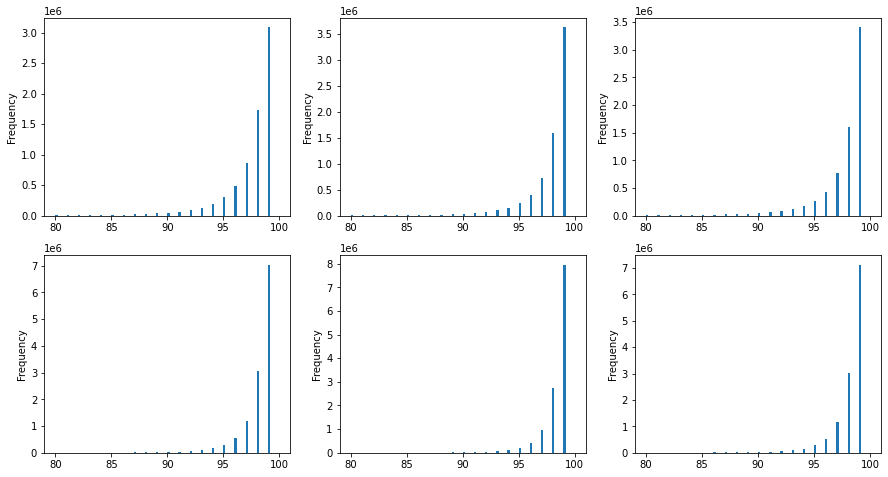

In [6]:
# Check that the changes were made properly
plt.figure(figsize = (15,8))
plt.subplot(231)
ADV1_qc['Correlation_B1(%)'].plot.hist(bins=100)
plt.subplot(234)
ADV2_qc['Correlation_B1(%)'].plot.hist(bins=100)

plt.subplot(232)
ADV1_qc['Correlation_B2(%)'].plot.hist(bins=100)
plt.subplot(235)
ADV2_qc['Correlation_B2(%)'].plot.hist(bins=100)

plt.subplot(233)
ADV1_qc['Correlation_B3(%)'].plot.hist(bins=100)
plt.subplot(236)
ADV2_qc['Correlation_B3(%)'].plot.hist(bins=100)

### ROLL AND PITCH

<AxesSubplot:ylabel='Frequency'>

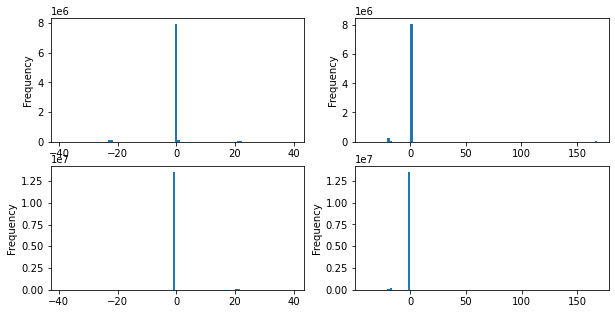

In [7]:
plt.figure(figsize = (10,5))
plt.subplot(221)
ADV1['Roll'].plot.hist(bins=100)
plt.subplot(223)
ADV2['Roll'].plot.hist(bins=100)

plt.subplot(222)
ADV1['Pitch'].plot.hist(bins=100)
plt.subplot(224)
ADV2['Pitch'].plot.hist(bins=100)

In [10]:
# For both Pitch and Roll, the margin of error appears extremely slim
# Safe to assume that most good data points fall within +/- 2 degrees, any tilt beyond this is likely to significantly bias data
# Keep all points withing this range
ADV1_qc = ADV1_qc[((ADV1_qc['Roll'] <= 2) & (ADV1_qc['Roll'] >= -2))]
ADV1_qc = ADV1_qc[((ADV1_qc['Pitch'] <= 2) & (ADV1_qc['Pitch'] >= -2))]

ADV2_qc = ADV2_qc[((ADV2_qc['Roll'] <= 2) & (ADV2_qc['Roll'] >= -2))]
ADV2_qc = ADV2_qc[((ADV2_qc['Pitch'] <= 2) & (ADV2_qc['Pitch'] >= -2))]

<AxesSubplot:ylabel='Frequency'>

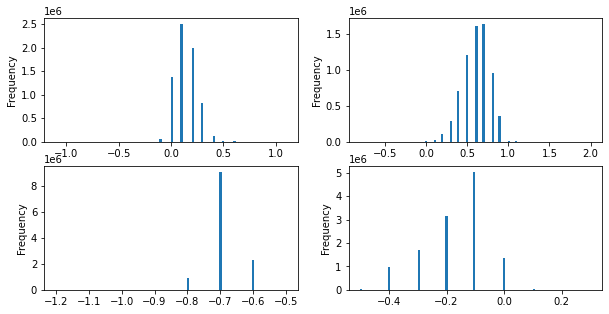

In [11]:
# Check that the subset removed the desired points
plt.figure(figsize = (10,5))
plt.subplot(221)
ADV1_qc['Roll'].plot.hist(bins=100)
plt.subplot(223)
ADV2_qc['Roll'].plot.hist(bins=100)

plt.subplot(222)
ADV1_qc['Pitch'].plot.hist(bins=100)
plt.subplot(224)
ADV2_qc['Pitch'].plot.hist(bins=100)

# NOTE: Upon further inspection of histograms, it seems reasonable to narrow the margin to +/- 2 degrees, for slightly greater accuracy

### PRESSURE

<AxesSubplot:ylabel='Frequency'>

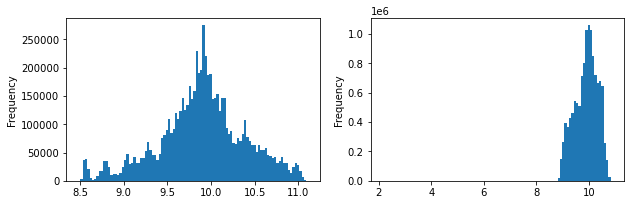

In [12]:
# Final preliminary check before phase wrapping is pressure, which should not exceed the reasonable bottom depth of the site
# Check that the subset removed the desired points
plt.figure(figsize = (10,3))
plt.subplot(121)
ADV1_qc['Pressure(dbar)'].plot.hist(bins=100)
plt.subplot(122)
ADV2_qc['Pressure(dbar)'].plot.hist(bins=100)

In [13]:
# Bottom depth of site was consistently 30-35 feet (~10m or 10dbar)
# Variability in pressure is due to tides and seems reasonable withing a 2m (~6 foot) change
# Filter subset to only keep data points above 8m
ADV1_qc = ADV1_qc[(ADV1_qc['Pressure(dbar)'] >= 8)]
ADV2_qc = ADV2_qc[(ADV2_qc['Pressure(dbar)'] >= 8)]

<AxesSubplot:ylabel='Frequency'>

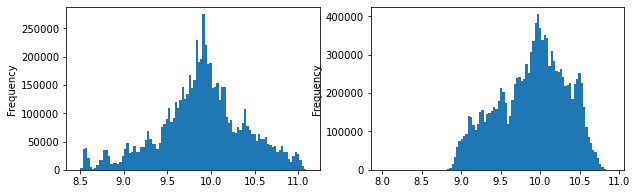

In [14]:
# Check filtered datasets
plt.figure(figsize = (10,3))
plt.subplot(121)
ADV1_qc['Pressure(dbar)'].plot.hist(bins=100)
plt.subplot(122)
ADV2_qc['Pressure(dbar)'].plot.hist(bins=100)

### POST FILTERING
- These filters account for most of the noise created by deployment and retrieval of the instruments, as well as noticeable 'bad data' during the deployment
- Distributions for all of the attributes accounted for now look far less skewed

In [15]:
# How much data was removed in hours
((len(ADV1) - len(ADV1_qc))/32)/3600
# 10.5 hrs in first deployment

15.152291666666667

In [16]:
((len(ADV2) - len(ADV2_qc))/32)/3600
# 5 hrs in second deployment

17.010546875

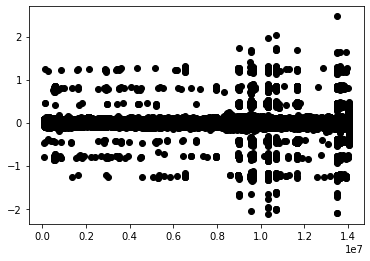

In [17]:
plt.plot(ADV2_qc['Velocity_East(m/s)'], 'ko')

In [18]:
#ADV1_qc.to_csv('ADV1_qc.csv')
#ADV2_qc.to_csv('ADV2_qc.csv')

### Convert data to xarray

In [2]:
ADV1 = pd.read_csv('ADV/ADV1_qc.csv')
ADV2 = pd.read_csv('ADV/ADV2_qc.csv')

In [4]:
ADV2

,Unnamed: 0,Datetime,Burst_counter,Ensemble_counter,Velocity_East(m/s),Velocity_North(m/s),Velocity_Up(m/s),Amplitude_B1(counts),Amplitude_B2(counts),Amplitude_B3(counts),...,Correlation_B3(%),Pressure(dbar),AnalogInput1,AnalogInput2,Checksum(1=failed),Soundspeed,Heading,Pitch,Roll,Temperature
0,76865,2022-08-15 08:40:02.031250,3,66,0.016,-0.024,0.002,98,89,92,...,99,9.031,0,0,0,1496.8,320.2,-0.4,-0.7,12.2
1,76866,2022-08-15 08:40:02.062500,3,67,-0.003,-0.020,-0.001,92,92,90,...,98,9.036,0,0,0,1496.8,320.2,-0.4,-0.7,12.2
2,76867,2022-08-15 08:40:02.093750,3,68,0.011,-0.022,0.000,88,101,97,...,99,9.036,0,0,0,1496.8,320.2,-0.4,-0.7,12.2
3,76868,2022-08-15 08:40:02.125000,3,69,0.009,-0.016,0.001,102,104,103,...,99,9.036,0,0,0,1496.8,320.2,-0.4,-0.7,12.2
4,76869,2022-08-15 08:40:02.156250,3,70,0.021,-0.023,0.001,105,105,107,...,99,9.041,0,0,0,1496.8,320.2,-0.4,-0.7,12.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12245141,14017574,2022-08-30 10:54:47.187500,366,1575,-0.057,0.008,-0.114,72,76,85,...,98,8.020,0,0,0,1500.2,320.2,-0.1,-0.6,12.9
12245142,14017575,2022-08-30 10:54:47.218750,366,1576,-0.055,0.012,-0.114,80,76,93,...,97,8.020,0,0,0,1500.2,320.2,-0.1,-0.6,12.9
12245143,14017576,2022-08-30 10:54:47.250000,366,1577,-0.063,0.047,-0.135,86,80,78,...,95,8.015,0,0,0,1500.2,320.2,-0.1,-0.6,12.9
12245144,14017577,2022-08-30 10:54:47.281250,366,1578,-0.060,0.025,-0.128,77,82,76,...,96,8.010,0,0,0,1500.2,320.2,-0.1,-0.6,12.9


In [6]:
# Merge both 1st and 2nd deployments of data
#adv = ADV1.append(ADV2)
adv = adv.drop('Unnamed: 0', axis=1)
adv

,Datetime,Burst_counter,Ensemble_counter,Velocity_East(m/s),Velocity_North(m/s),Velocity_Up(m/s),Amplitude_B1(counts),Amplitude_B2(counts),Amplitude_B3(counts),SNR_B1(dB),...,Correlation_B3(%),Pressure(dbar),AnalogInput1,AnalogInput2,Checksum(1=failed),Soundspeed,Heading,Pitch,Roll,Temperature
0,2022-08-02 10:46:32.031250,2,12546,-0.025,-0.035,0.000,99,93,88,24.9,...,99,9.418,0,0,0,1521.4,84.4,-0.6,0.6,19.84
1,2022-08-02 10:46:32.062500,2,12547,0.001,-0.016,0.010,93,95,94,22.4,...,99,9.413,0,0,0,1521.4,84.4,-0.6,0.6,19.84
2,2022-08-02 10:46:32.093750,2,12548,0.009,-0.006,0.008,93,94,86,22.4,...,97,9.423,0,0,0,1521.4,84.4,-0.6,0.6,19.84
3,2022-08-02 10:46:32.125000,2,12549,0.021,0.003,-0.001,103,100,97,26.7,...,99,9.428,0,0,0,1521.4,84.4,-0.6,0.6,19.84
4,2022-08-02 10:46:32.156250,2,12550,-0.015,-0.025,-0.001,101,99,96,25.8,...,98,9.418,0,0,0,1521.4,84.4,-0.6,0.6,19.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12245141,2022-08-30 10:54:47.187500,366,1575,-0.057,0.008,-0.114,72,76,85,12.9,...,98,8.020,0,0,0,1500.2,320.2,-0.1,-0.6,12.90
12245142,2022-08-30 10:54:47.218750,366,1576,-0.055,0.012,-0.114,80,76,93,16.3,...,97,8.020,0,0,0,1500.2,320.2,-0.1,-0.6,12.90
12245143,2022-08-30 10:54:47.250000,366,1577,-0.063,0.047,-0.135,86,80,78,18.9,...,95,8.015,0,0,0,1500.2,320.2,-0.1,-0.6,12.90
12245144,2022-08-30 10:54:47.281250,366,1578,-0.060,0.025,-0.128,77,82,76,15.0,...,96,8.010,0,0,0,1500.2,320.2,-0.1,-0.6,12.90


In [7]:
adv['Datetime'] = pd.to_datetime(adv['Datetime'])
adv['Datetime']

0          2022-08-02 10:46:32.031250
1          2022-08-02 10:46:32.062500
2          2022-08-02 10:46:32.093750
3          2022-08-02 10:46:32.125000
4          2022-08-02 10:46:32.156250
                      ...            
12245141   2022-08-30 10:54:47.187500
12245142   2022-08-30 10:54:47.218750
12245143   2022-08-30 10:54:47.250000
12245144   2022-08-30 10:54:47.281250
12245145   2022-08-30 10:54:47.312500
Name: Datetime, Length: 19139602, dtype: datetime64[ns]

In [8]:
adv_hvel = np.sqrt(((adv['Velocity_East(m/s)'])**2) + ((adv['Velocity_North(m/s)'])**2))
adv_dir = np.arctan(adv['Velocity_North(m/s)']/adv['Velocity_East(m/s)']) + adv['Heading']

In [9]:
# create coords
time = pd.to_datetime(adv['Datetime'])

# put data into a dataset
adv_ds = xr.Dataset(
    data_vars=dict(
        East = (["time"], adv['Velocity_East(m/s)']),
        North = (["time"], adv['Velocity_North(m/s)']),
        Vertical = (["time"], adv['Velocity_Up(m/s)']),
        Magnitude = (["time"], adv_hvel),
        Direction = (["time"], adv_dir),
        Heading = (["time"], adv['Heading']),
        Pitch = (["time"], adv['Pitch']),
        Roll = (["time"], adv['Roll']),
        Temperature = (["time"], adv['Temperature']),
        Pressure = (["time"], adv['Pressure(dbar)']),
        Correlation_B1 = (["time"], adv['Correlation_B1(%)']),
        Correlation_B2 = (["time"], adv['Correlation_B2(%)']),
        Correlation_B3 = (["time"], adv['Correlation_B3(%)'])
    ),
    coords=dict(
        time=(["time"], time)
    ),
    attrs=dict(description="ADV data"),
)

adv_ds['East'].attrs['units'] = 'm/s'
adv_ds['North'].attrs['units'] = 'm/s'
adv_ds['Vertical'].attrs['units'] = 'm/s'
adv_ds['Magnitude'].attrs['units'] = 'm/s'
adv_ds['Magnitude'].attrs['description'] = 'Magnitude of horizontal velocity from Eastern and Northern vectors'
adv_ds['Direction'].attrs['units'] = 'Degrees'
adv_ds['Direction'].attrs['description'] = 'True direction of horizontal velocity (direction of vector added to the heading of the instrument)'
adv_ds['Heading'].attrs['units'] = 'Degrees'
adv_ds['Heading'].attrs['description'] = 'Direction of the instrument'
adv_ds['Pitch'].attrs['units'] = 'Degrees'
adv_ds['Roll'].attrs['units'] = 'Degrees'
adv_ds['Temperature'].attrs['units'] = 'Celsius'
adv_ds['Pressure'].attrs['units'] = 'dbar'
adv_ds['Correlation_B1'].attrs['units'] = '%'
adv_ds['Correlation_B1'].attrs['units'] = '%'
adv_ds['Correlation_B1'].attrs['units'] = '%'

In [10]:
adv_ds

<xarray.Dataset>
Dimensions:         (time: 19139602)
Coordinates:
  * time            (time) datetime64[ns] 2022-08-02T10:46:32.031250 ... 2022...
Data variables:
    East            (time) float64 -0.025 0.001 0.009 ... -0.063 -0.06 -0.031
    North           (time) float64 -0.035 -0.016 -0.006 ... 0.047 0.025 0.037
    Vertical        (time) float64 0.0 0.01 0.008 ... -0.135 -0.128 -0.111
    Magnitude       (time) float64 0.04301 0.01603 0.01082 ... 0.065 0.04827
    Direction       (time) float64 85.35 82.89 83.81 84.54 ... 319.6 319.8 319.3
    Heading         (time) float64 84.4 84.4 84.4 84.4 ... 320.2 320.2 320.2
    Pitch           (time) float64 -0.6 -0.6 -0.6 -0.6 ... -0.1 -0.1 -0.1 -0.1
    Roll            (time) float64 0.6 0.6 0.6 0.6 0.6 ... -0.6 -0.6 -0.6 -0.6
    Temperature     (time) float64 19.84 19.84 19.84 19.84 ... 12.9 12.9 12.9
    Pressure        (time) float64 9.418 9.413 9.423 9.428 ... 8.015 8.01 8.0
    Correlation_B1  (time) int64 99 98 97 97 99 99 99 ... 95 95 95 93 93 97 96
    Correlation_B2  (time) int64 98 98 99 99 98 99 99 ... 97 95 95 96 96 99 97
    Correlation_B3  (time) int64 99 99 97 99 98 99 99 ... 96 95 98 97 95 96 96
Attributes:
    description:  ADV data

In [11]:
adv_ds.to_netcdf('ADV/adv_qc.nc')

# PHASE WRAPPING
- Phase wrapping occurs when velocity is greater than the set velocity range of the instrument
    - E.G. If the range is +/- 3m/s, a velocity change from 3 to 3.1m/s will 'wrap' from 3m/s to -2.9m/s
- Steps to check for and fix phase wrapping include:
    - Check if there are any abrupt changes in sign that exceed the max velocity range
        - Instrument is sampling at 32Hz, so changes from positive to negative are fairly common at lower velocities, but a sudden change from
        3m/s to -3m/s in a few milliseconds is highly unlikely
    - If phase wrapping is present, convert ENU velocity to BEAM velocity using steps from NORTEK support
        - Most relevant information is available in the .hdr file
        - You will need the transformation matrix, as well as heading, pitch, and roll data for each sample to make the conversions
    - Once velocities have been converted, calculate the ambiguous velocity V_amb
    - Run a patch over the entire BEAM velocity dataset
        - If phase wrap is negative: newvel = oldvel + 2*V_amb
        - If phase wrap is positive: newvel = oldvel - 2*V_amb
    -Convert patched velocities back to ENU for more user-friendly data

In [81]:
ADV1_qc['Datetime'] = pd.to_datetime(ADV1_qc['Datetime'])
ADV2_qc['Datetime']

76865       2022-08-15 08:40:02.031250
76866       2022-08-15 08:40:02.062500
76867       2022-08-15 08:40:02.093750
76868       2022-08-15 08:40:02.125000
76869       2022-08-15 08:40:02.156250
                       ...            
14017574    2022-08-30 10:54:47.187500
14017575    2022-08-30 10:54:47.218750
14017576    2022-08-30 10:54:47.250000
14017577    2022-08-30 10:54:47.281250
14017578    2022-08-30 10:54:47.312500
Name: Datetime, Length: 12245146, dtype: object

2.543582810889529

(array([19207., 19208., 19209., 19210., 19211., 19212., 19213., 19214.,
        19215.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

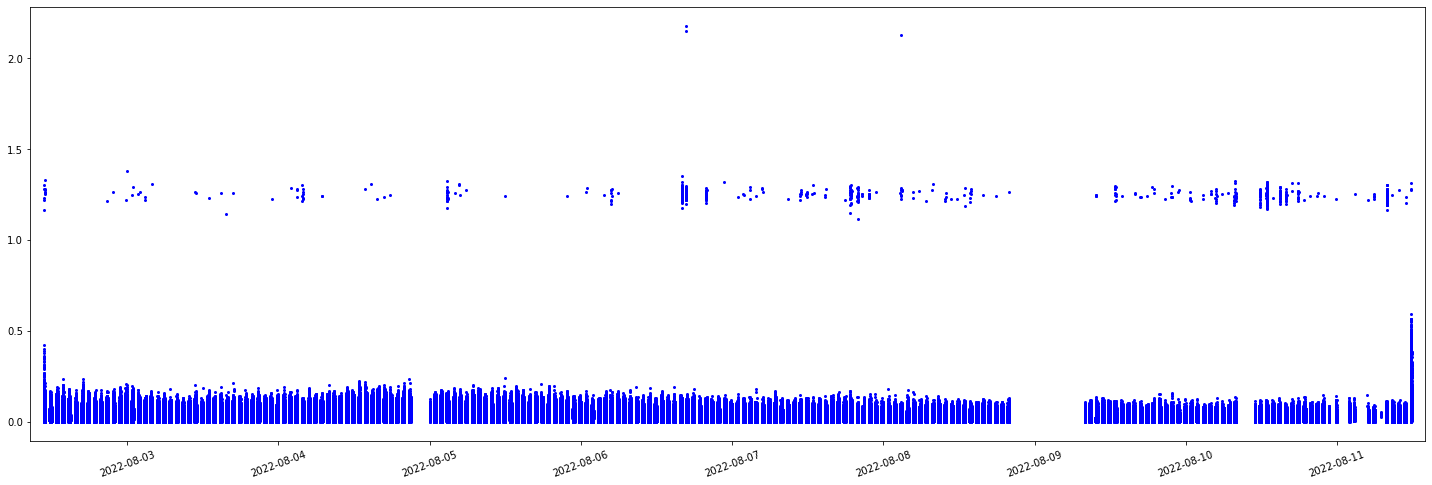

In [80]:
plt.figure(figsize = (25, 8))
#plt.plot(ADV1_qc['Datetime'], ADV1_hvel, 'bo', ms = 2)
plt.plot(ADV1_qc.iloc[:,0], ADV1_hvel, 'bo', ms = 2)
plt.margins(x=.01)
plt.xticks(rotation=20)

Text(0.5, 0, 'Roll (degrees)')

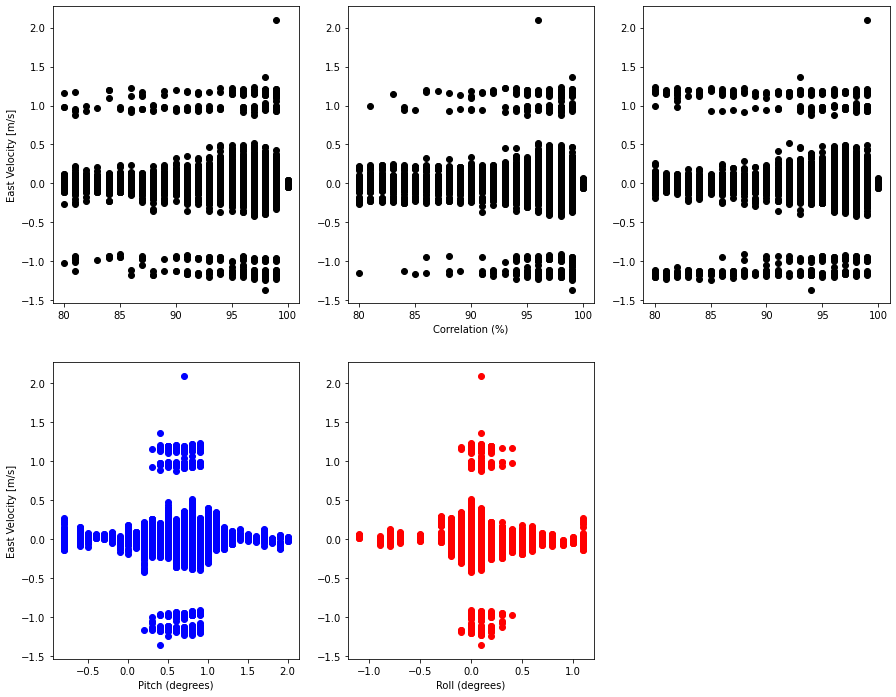

In [56]:
# Check that the changes were made properly
plt.figure(figsize = (15,12))
plt.subplot(231)
plt.ylabel('East Velocity [m/s]')
plt.plot(ADV1_qc['Correlation_B1(%)'], ADV1_qc['Velocity_East(m/s)'], 'ko')

plt.subplot(232)
plt.plot(ADV1_qc['Correlation_B2(%)'], ADV1_qc['Velocity_East(m/s)'], 'ko')
plt.xlabel('Correlation (%)')
plt.title('Eastern Velocity vs. Sensor parameters - 1st deployment')

plt.subplot(233)
plt.plot(ADV1_qc['Correlation_B3(%)'], ADV1_qc['Velocity_East(m/s)'], 'ko')

plt.subplot(234)
plt.plot(ADV1_qc['Pitch'], ADV1_qc['Velocity_East(m/s)'], 'bo')
plt.ylabel('East Velocity [m/s]')
plt.xlabel('Pitch (degrees)')

plt.subplot(235)
plt.plot(ADV1_qc['Roll'], ADV1_qc['Velocity_East(m/s)'], 'ro')
plt.xlabel('Roll (degrees)')

Text(0.5, 0, 'Roll (degrees)')

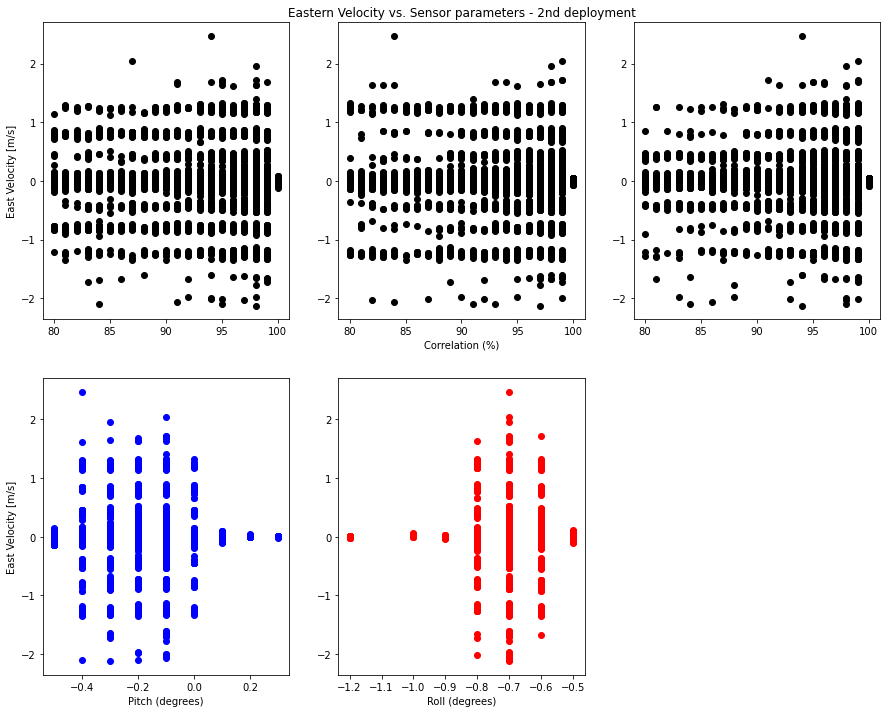

In [57]:
# Check that the changes were made properly
plt.figure(figsize = (15,12))
plt.subplot(231)
plt.ylabel('East Velocity [m/s]')
plt.plot(ADV2_qc['Correlation_B1(%)'], ADV2_qc['Velocity_East(m/s)'], 'ko')

plt.subplot(232)
plt.plot(ADV2_qc['Correlation_B2(%)'], ADV2_qc['Velocity_East(m/s)'], 'ko')
plt.xlabel('Correlation (%)')
plt.title('Eastern Velocity vs. Sensor parameters - 2nd deployment')

plt.subplot(233)
plt.plot(ADV2_qc['Correlation_B3(%)'], ADV2_qc['Velocity_East(m/s)'], 'ko')

plt.subplot(234)
plt.plot(ADV2_qc['Pitch'], ADV2_qc['Velocity_East(m/s)'], 'bo')
plt.ylabel('East Velocity [m/s]')
plt.xlabel('Pitch (degrees)')

plt.subplot(235)
plt.plot(ADV2_qc['Roll'], ADV2_qc['Velocity_East(m/s)'], 'ro')
plt.xlabel('Roll (degrees)')

### Check for phase wrapping by looking at abrupt changes in the sign (+/-)

In [171]:
posval = np.absolute(np.max(ADV2_qc.iloc[:,4]))
negval = np.absolute(np.min(ADV2_qc.iloc[:,4]))
for i in range(0, len(ADV2_qc)-1, 1):
    delta = np.absolute(ADV2_qc.iloc[i,4] - ADV2_qc.iloc[i+1,4])
    if ADV2_qc.iloc[i,4] > 0 and delta > posval:
        print(i)
    elif ADV2_qc.iloc[i,4] < 0 and delta > negval:
        print(i)
    else:
        pass

7802641
7807025
7807515
7807912
8340072
8340194
8340264
8340267
8340342
8340502
8340646
8364778
8371531
8386473
8386485
8386486
8386488
8387066
8387450
8387503
8399982
8431986
8438260
9096397
9096398
9096525
9096761
9097371
9097628
9417119
9417120
9417121
9417124
9417133
9417137
9417141
9417386
9439029
10058324
10058354
10059091
10059094
10060794
11780832
11781004
11781178
11781206
11781268
11781278
11781288
11781315
11781602
11781727
11781743
11782380
11782383
11782937
11783332
11910515
11911494
11911495
11913149
12053439


IndexError: single positional indexer is out-of-bounds

In [168]:
#3, 4, 5 column #
#ADV2_qc = ADV2_qc.reset_index(drop=True)
#ADV2_qc['Velocity_East(m/s)'].idxmax()
ADV2_qc['Velocity_North(m/s)'].idxmax()
#ADV2_qc['Velocity_Up(m/s)'].idxmax()

9417386

In [169]:
#ADV2_qc['Velocity_East(m/s)'].max()
ADV2_qc['Velocity_North(m/s)'].max()
#ADV2_qc['Velocity_Up(m/s)'].max()

2.2880000000000003

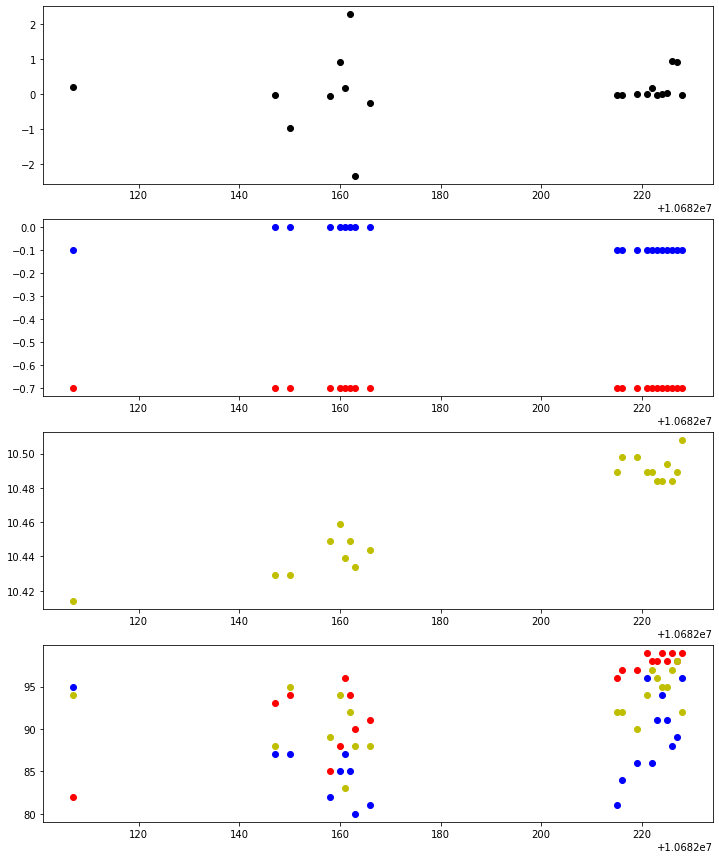

In [25]:
plt.figure(figsize = (12,15))
plt.subplot(411)
plt.plot(ADV2_qc.iloc[9417380:9417400, 4], 'ko')

plt.subplot(412)
plt.plot(ADV2_qc.iloc[9417380:9417400, 21], 'bo')
plt.plot(ADV2_qc.iloc[9417380:9417400, 22], 'ro')

plt.subplot(413)
plt.plot(ADV2_qc.iloc[9417380:9417400, 15], 'yo')

plt.subplot(414)
plt.plot(ADV2_qc.iloc[9417380:9417400, 12], 'bo')
plt.plot(ADV2_qc.iloc[9417380:9417400, 13], 'ro')
plt.plot(ADV2_qc.iloc[9417380:9417400, 14], 'yo')

### Convert velocities from ENU to beam by using the transformation matrix in .hdr files
- The following code is based on a MatLab script available on NORTEK's FAQ forums:
https://support.nortekgroup.com/hc/en-us/articles/360029820971-How-is-a-coordinate-transformation-done-

In [ ]:
T = [[2.7249, -1.3770, -1.3503],
   [-0.0161, 2.3442, -2.3308],
   [0.3472, 0.3455, 0.3389]]

#Scale the transformation matrix correctly to floating point numbers
T = T/4096 #Scale the transformation matrix correctly to floating point numbers

#Heading, pitch and roll are the angles output in the data in degrees
#Convert to radians

hh = pi*(heading-90)/180
pp = pi * pitch/180
rr = pi * roll/180

#Make heading matrix
H = [[cos(hh), sin(hh), 0],
    [-sin(hh), cos(hh), 0],
    [0, 0, 1]]

#Make tilt matrix
P = [[cos(pp), -sin(pp)*sin(rr), -cos(rr)*sin(pp)],
     [0, cos(rr), -sin(rr)],
     [sin(pp), sin(rr)*cos(pp), cos(pp)*cos(rr)]]

#Make resulting transformation matrix
R = H*P*T

#Given ENU velocities, beam coordinates are calculated as
beam = inv(R)*enu

### Calculate v_amb
 - v_amb = VR * 2
 - VR = c/(4 * f * tlag(s))
 - c = 1530 (speed of sound measured by instrument)
 - f = instrument frequency (6000kHz)
 - tlag (for vector) = 50/480000 (50 is from system 38 in .hdr file, which indicates nominal velocity of 1m/s)

In [68]:
c = 1530
f = 6000000
tlag = 50/480000
VR = c / (4 * f * tlag)
v_amb = VR *2
v_amb

1.224

In [60]:
v_amb = (1530 / (4 * (6000000 * 0.00010416666666666667))) * 2

In [66]:
v_amb * 2

2.448

In [87]:
posval = np.absolute(np.max(adv_dat_qc.iloc[:,4]))
negval = np.absolute(np.min(adv_dat_qc.iloc[:,4]))
(posval + negval) / 2

3.1734999999999998

In [128]:
(1 * np.pi) + (2 * 0.1372)

3.415992653589793

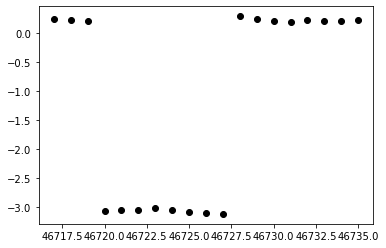

In [109]:
# Affected values 44-51
plt.plot(adv_dat_qc.iloc[541:560,4], 'ko')

In [110]:
testdf = adv_dat_qc
testdf

,Unnamed: 0,Datetime,Burst_counter,Ensemble_counter,Velocity_East(m/s),Velocity_North(m/s),Velocity_Up(m/s),Amplitude_B1(counts),Amplitude_B2(counts),Amplitude_B3(counts),SNR_B1(dB),SNR_B2(dB),SNR_B3(dB),Correlation_B1(%),Correlation_B2(%),Correlation_B3(%),Pressure(dbar),AnalogInput1,AnalogInput2,Checksum(1=failed)
6880,6880,2022-08-02 09:43:37.000000,1,6881,-0.329,0.595,-0.154,41,42,43,-2.1,-1.7,-0.9,9,24,76,0.000,0,0,0
10081,10081,2022-08-02 09:45:17.031250,1,10082,1.317,-0.666,0.123,42,42,42,-1.7,-1.7,-1.3,41,20,70,0.000,0,0,0
10413,10413,2022-08-02 09:45:27.406250,1,10414,-0.069,0.160,-0.137,41,44,42,-2.1,-0.9,-1.3,28,21,71,0.000,0,0,0
13603,13603,2022-08-02 09:47:07.093750,1,13604,-0.170,-1.206,0.579,42,43,42,-1.7,-1.3,-1.3,17,72,11,0.000,0,0,0
23528,23528,2022-08-02 09:52:17.250000,1,23529,1.312,1.487,-0.887,40,39,44,-2.6,-3.0,-0.4,28,75,17,0.000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22816372,14176372,2022-08-30 14:57:25.625000,370,6773,0.775,0.586,-0.627,40,41,40,-0.4,-0.4,-0.4,73,46,13,0.034,0,0,0
22818435,14178435,2022-08-30 14:58:30.093750,370,8836,-0.769,-0.114,0.260,40,41,40,-0.4,-0.4,-0.4,16,22,70,0.034,0,0,0
22832716,14192716,2022-08-30 15:45:55.375000,370,23117,0.095,-1.315,0.798,41,39,41,0.0,-1.3,0.0,73,35,19,0.049,0,0,0
22833727,14193727,2022-08-30 15:46:26.968750,370,24128,-2.729,0.234,-0.109,41,41,40,0.0,-0.4,-0.4,71,25,19,0.039,0,0,0


In [131]:
# - ((posval + negval) / 2)
# 3.1734999999999998
testdf.iloc[544:552,4] = testdf.iloc[544:552,4] + 3.415992653589793

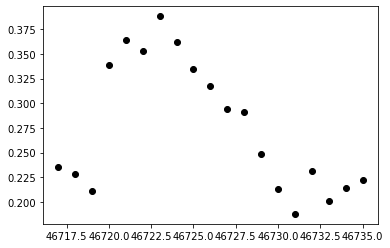

In [132]:
plt.plot(testdf.iloc[541:560,4], 'ko')

# ANALYSIS

### Wave Excursion

In [30]:
# Calculate the magnitude of ADV velocity
ADV1_hvel = ((ADV1_qc['Velocity_East(m/s)'])**2) + ((ADV1_qc['Velocity_North(m/s)'])**2)
ADV2_hvel = ((ADV2_qc['Velocity_East(m/s)'])**2) + ((ADV2_qc['Velocity_North(m/s)'])**2)

In [38]:
np.mean(ADV1_hvel)*100

0.17559164691058443

In [37]:
np.std(ADV1_hvel)*100

1.8011597591776285

In [39]:
np.mean(ADV2_hvel)*100

0.20338992054437732

In [40]:
np.std(ADV2_hvel)*100

2.4592097776092916